# Курсовой проект
Ник на kaggle:
daniilmartsenyuk

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

### Загрузка данных

In [3]:
train_df = pd.read_csv(r'C:\Users\Даниил\Downloads\train.csv')
test_df = pd.read_csv(r'C:\Users\Даниил\Downloads\test.csv')

### Классы для обработки данных

In [4]:
class DataPreprocessor:
    
    def __init__(self):
        self.medians = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None
        
    def fit(self, df):
        self.medians = df.median()
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.995) 
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.005) 
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03) 
        self.max_floor = df['Floor'].max()
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        df['LifeSquare'].fillna((0.8 * df['Square'] - df['KitchenSquare']), inplace=True)
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'], (df['LifeSquare'], df['Square']), (df['Square'], df['LifeSquare']))

        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, 'Square'] - df.loc[ls_condition, 'KitchenSquare']
  
        ks_condition = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[ks_condition, 'KitchenSquare'] = 0.9 * df.loc[ks_condition, 'Square'] - df.loc[ks_condition, 'LifeSquare']

        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        hf_condition = df['HouseFloor'] < df['Floor']
        df.loc[hf_condition, 'HouseFloor'] = df.loc[hf_condition, 'Floor']

        current_year = datetime.now().year
        year_condition = (df['HouseYear'] > current_year)
        df.loc[year_condition, 'HouseYear'] = self.medians.HouseYear
           
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)

        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        df.drop(['Id'], axis=1, inplace=True)

        df.fillna(self.medians, inplace=True)
        return df

In [5]:
class FeatureGenerator:
    
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None


    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') / df.groupby(['DistrictId'])['Square'].agg('median')
    
    def new_features(self, df):  
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)

        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)

        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)

        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 
 
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
    
        df.drop(['Floor'], axis=1, inplace=True)
#'Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2',
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        return df

#### Предобработка данных

In [6]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

#### Генерация признаков

In [7]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)

#### Визуализации

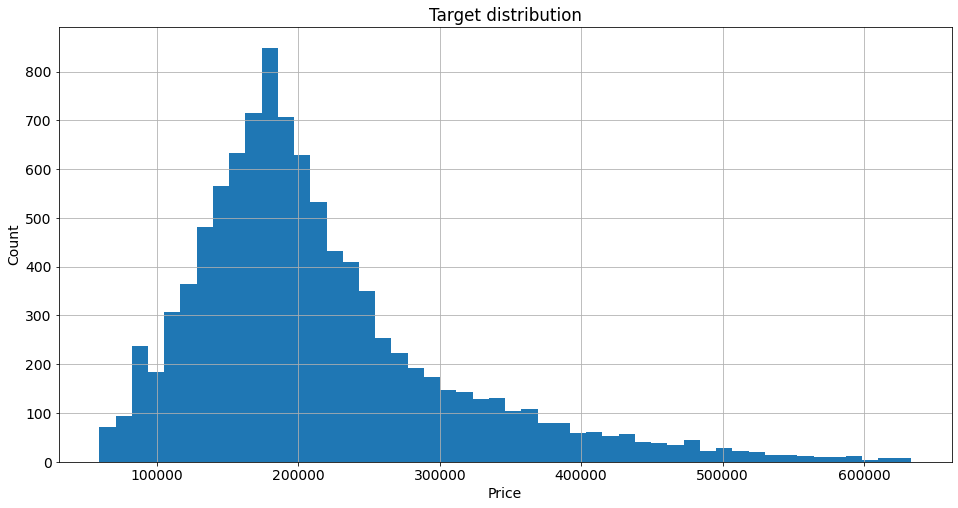

In [8]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution');

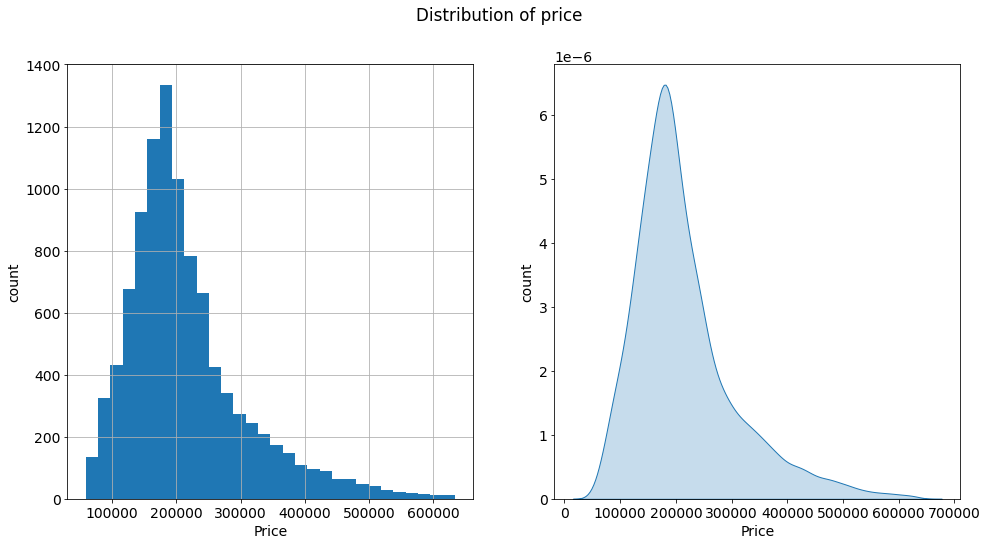

In [9]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('count')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True)
plt.xlabel('Price')
plt.ylabel('count')

target_mean = train_df['Price'].mean()
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]
plt.suptitle('Distribution of price');

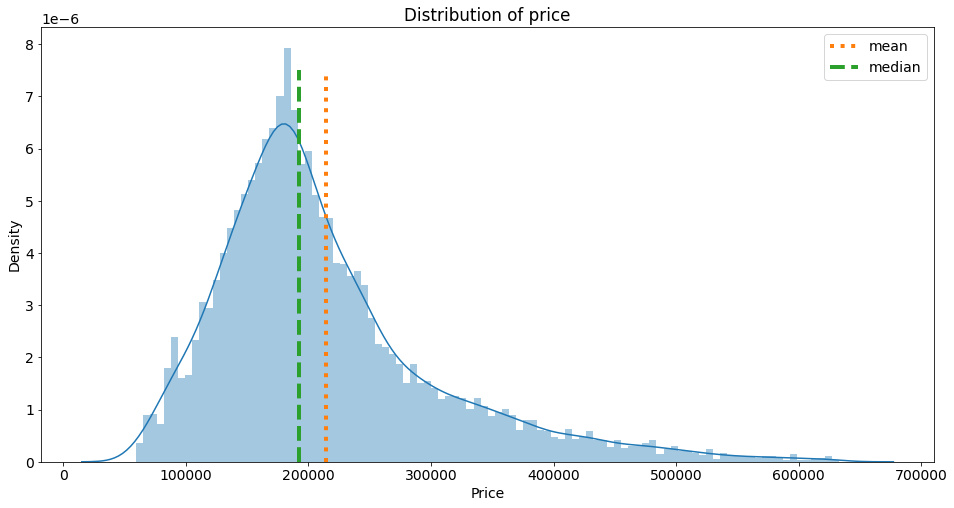

In [10]:
target_mean = train_df['Price'].mean()
target_median = train_df['Price'].median()

plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=100)

y = np.linspace(0, 0.0000075, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)

plt.title('Distribution of price')
plt.legend();

In [11]:
features = train_df.drop('Price', axis=1)
features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
0,27,3.0,115.027311,82.021849,10.0,10.0,2014.0,0.075424,1,1,...,0,900.00000,0,0,1,1977.0,55.064041,2654.571480,0,-1.613625
1,22,1.0,39.832524,23.169223,8.0,8.0,1966.0,0.118537,1,1,...,1,1183.00000,1,0,1,1977.0,48.013256,3825.571310,1,-1.405498
2,1,3.0,78.342215,47.671972,10.0,17.0,1988.0,0.025609,1,1,...,0,240.00000,3,1,1,1977.0,60.631137,3029.193475,0,-1.607039
3,1,1.0,40.409907,31.327926,1.0,22.0,1977.0,0.007122,1,1,...,0,228.77193,0,1,1,1977.0,60.631137,3029.193475,2,-1.620274
4,94,2.0,64.285067,38.562517,9.0,16.0,1972.0,0.282798,1,1,...,2,900.00000,0,6,1,1976.0,45.293988,4011.718265,3,-1.200334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,2.0,49.090728,33.272626,6.0,12.0,1981.0,0.300323,1,1,...,6,80.00000,1,9,1,1980.0,52.370859,4253.754594,0,-0.395144
9996,27,2.0,64.307684,37.038420,9.0,13.0,1977.0,0.072158,1,1,...,1,900.00000,0,0,0,1977.0,55.064041,2654.571480,3,-1.419461
9997,178,1.0,29.648057,16.555363,5.0,5.0,1958.0,0.460556,1,1,...,14,628.00000,1,5,1,1970.0,43.027020,4761.159925,0,1.189678
9998,21,1.0,32.330292,22.326870,5.0,9.0,1969.0,0.194489,1,1,...,3,125.00000,3,5,1,1970.0,45.924009,3958.272059,0,-1.000188


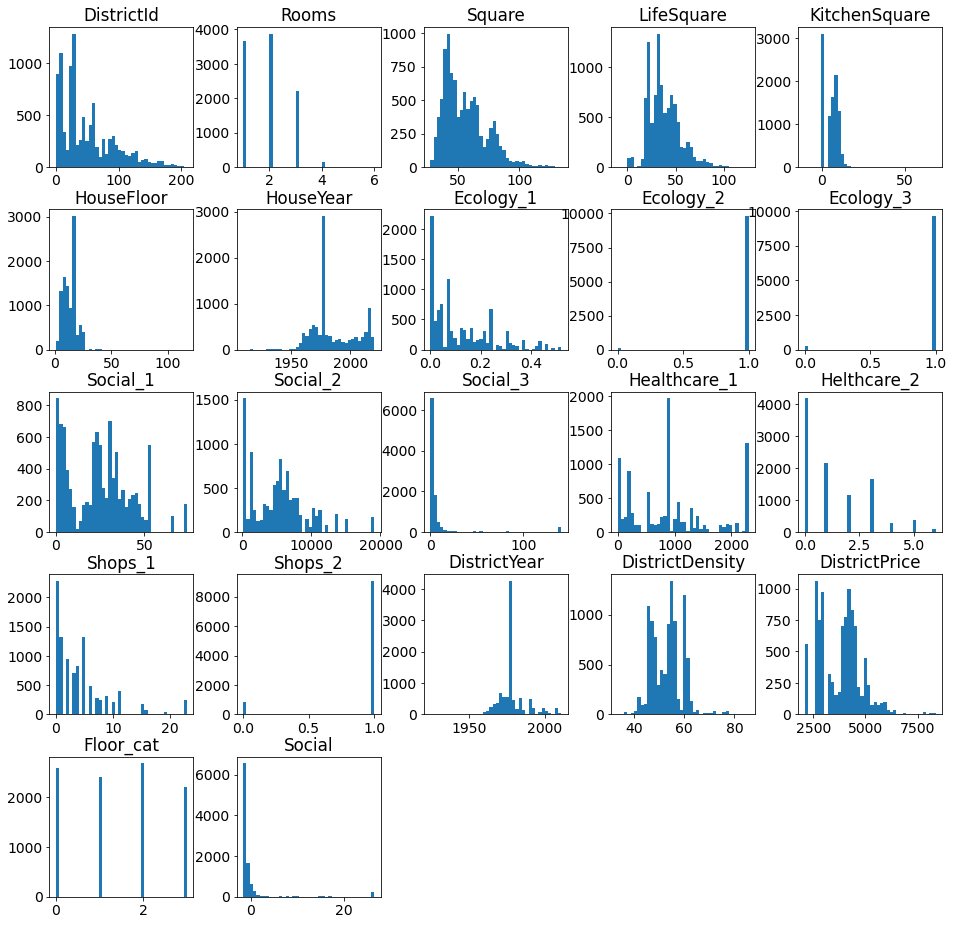

In [12]:
features.hist(figsize=(16,16), bins=40, grid=False);

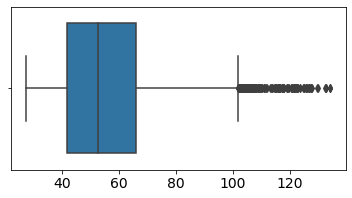

In [13]:
plt.figure(figsize=(6, 3))
sns.boxplot(train_df['Square'])
plt.xlabel('');

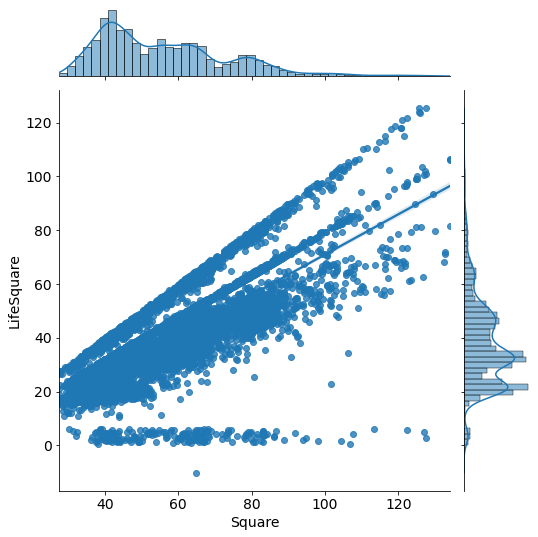

In [14]:
grid = sns.jointplot(train_df['Square'], train_df['LifeSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

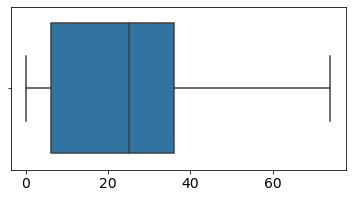

In [15]:
plt.figure(figsize=(6, 3))
sns.boxplot(train_df['Social_1'])
plt.xlabel('');

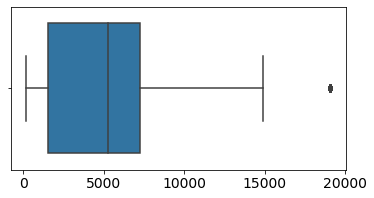

In [16]:
plt.figure(figsize=(6, 3))
sns.boxplot(train_df['Social_2'])
plt.xlabel('');

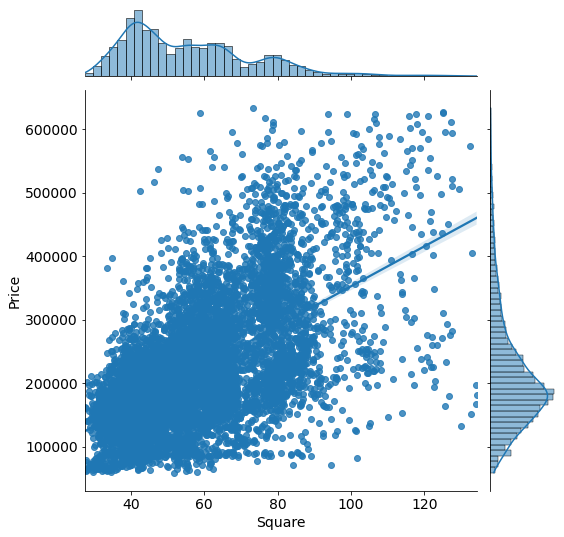

In [17]:
grid = sns.jointplot(train_df['Square'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

#### Обучение

In [18]:
X, y = train_df.drop(columns="Price"), train_df["Price"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.15, random_state=100)

In [19]:
X_train.shape, X_valid.shape, test_df.shape

((8415, 22), (1485, 22), (5000, 22))

In [20]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [21]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber',
                                     learning_rate=0.025)

In [22]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250)

#### Оценка

In [23]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction');

In [24]:
y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

Train R2:	0.861
Test R2:	0.797


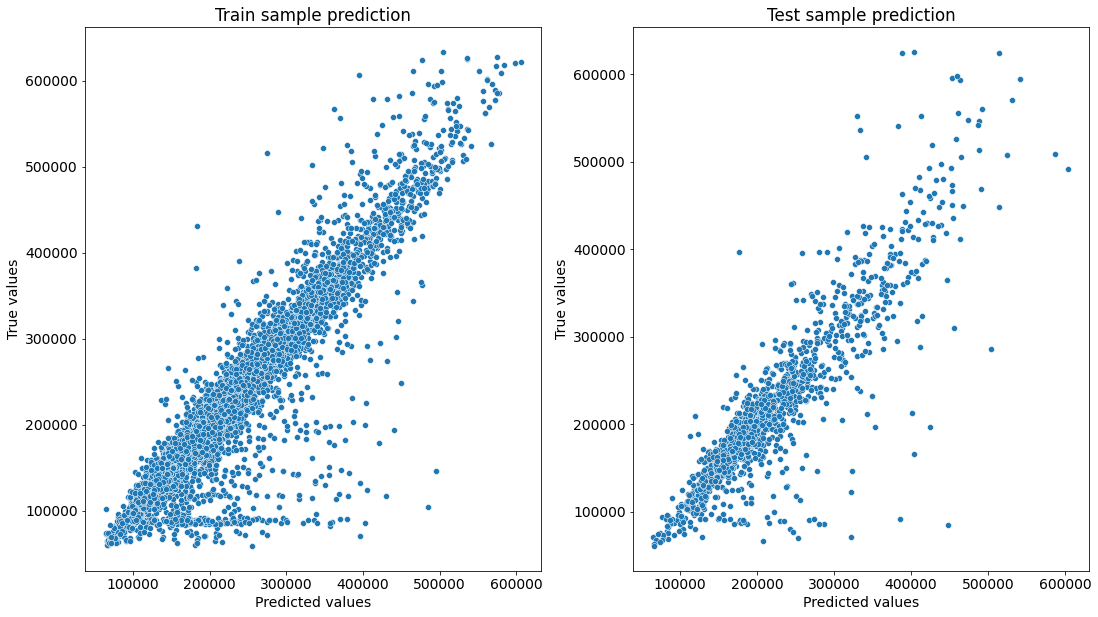

In [25]:
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#### Финальное предсказание

In [26]:
submit = pd.read_csv(r'C:\Users\Даниил\Downloads\sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [27]:
predictions = gb_model.predict(test_df)
predictions

array([161475.32534858, 124936.90239817, 138785.67368277, ...,
       150044.36543588, 187167.85210499, 301904.31853521])

In [28]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161475.325349
1,5925,124936.902398
2,960,138785.673683
3,3848,85615.037360
4,746,185109.072602


In [29]:
submit.shape

(5000, 2)

In [30]:
submit.to_csv('gb_submit.csv', index=False)